# Aligning Diarization

In [1]:
import re
import pickle
import glob
import os
import pandas as pd
import pandas as pd
from pydub import AudioSegment
import os
from transformers import pipeline
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from transformers import pipeline
import torch
import librosa
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.metrics.segmentation import SegmentationCoverage, SegmentationPurity
from pyannote.audio.pipelines.utils.hook import ProgressHook
from pyannote.core import Timeline, Segment
from pyannote.database.util import load_rttm
from pyannote.audio import Pipeline

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

In [69]:
with open("whisper_diarizations.pkl", 'rb') as f:
    all_diarizations = pickle.load(f)

In [7]:
folder_path = "Audio_Files/"
audio_files = os.listdir(folder_path)[:-1]

label_folder_path = "Label_Files/"
label_files = os.listdir(label_folder_path)

In [13]:
audio_diarization_dict = dict(zip(audio_files, all_diarizations))

In [23]:
diarization_dict = {}
merged_diarization_dict = {}

In [26]:
for key, value in audio_diarization_dict.items():
    clip_name = key.split(".")[0]
    diarization = value

In [83]:
for key, value in audio_diarization_dict.items():

    clip_name = key.split(".")[0]
    diarization = value

    diarization_df = value
    
    diarization_df['speaker'] = diarization_df["teacher_talk"].apply(lambda x: 'Teacher' if x==True  else 'Student')
    diarization_df.columns = ["start", "end", "teacher_talk", "speaker"]
    diarization_df = diarization_df.drop(['teacher_talk'], axis=1)

    merged_data = []
    
    for i in range(0, len(diarization_df)-1, 2):
        if ( (  (i + 1) < len(diarization_df)  ) & (diarization_df.iloc[i, 2] == diarization_df.iloc[i + 1, 2]) ):
      #  if ( (  (i + 1) < len(diarization_df)  ) & (diarization_df.loc[i, 'speaker'] == diarization_df.loc[i + 1, 'speaker']) ):
            merged_row = {
                'start': diarization_df.loc[i, 'start'],
                'end': diarization_df.loc[i + 1, 'end'],
                'speaker': diarization_df.loc[i, 'speaker']
            }
            merged_data.append(merged_row)
        else:
            merged_data.append(diarization_df.iloc[i].to_dict())
            if i + 1 < len(diarization_df):
                merged_data.append(diarization_df.iloc[i + 1].to_dict())
                
    merged_df = pd.DataFrame(merged_data)
    
    diarization_dict[f"{clip_name}"] = diarization_df
    merged_diarization_dict[f"{clip_name}"] = merged_df

In [87]:
metrics_list = []

In [88]:
for key, df in diarization_dict.items():
    df["duration"] = df["end"] - df["start"]
    df["duration"] = pd.to_numeric(df["duration"], errors="coerce")  # Coerce errors to NaN if not numeric
    max_speaker = df.groupby("speaker")["duration"].sum().idxmax()
    

    df.loc[df["speaker"] == max_speaker, "speaker"] = "Teacher"
    df.loc[(~(df["speaker"] == "Teacher") & (df["speaker"] != "Silence")) , "speaker"] = "Student"
    
     # Calculate the percentage of rows for each speaker
    speaker_counts = df["speaker"].value_counts(normalize=True)
    teacher_percentage = speaker_counts.get("Teacher", 0)  # default to 0 if "Teacher" is not in the counts
    student_percentage = speaker_counts.get("Student", 0)  # default to 0 if "Student" is not in the counts

    # Calculate the total duration for each speaker
    teacher_duration = df[df["speaker"] == "Teacher"]["duration"].sum()
    student_duration = df[df["speaker"] == "Student"]["duration"].sum()

    # Append the calculated metrics as a dictionary
    metrics_list.append({
        "clip": key,
        "teacher_percentage": teacher_percentage,
        "student_percentage": student_percentage,
        "teacher_duration": teacher_duration,
        "student_duration": student_duration
   #     "silence_duration": silence_duration
    })

# Create a DataFrame from the metrics list
diarization_metrics_df = pd.DataFrame(metrics_list)

In [91]:
# Check to make sure teachers are not talking more than students
diarization_metrics_df[diarization_metrics_df["teacher_duration"] < diarization_metrics_df["student_duration"]]

,clip,teacher_percentage,student_percentage,teacher_duration,student_duration


In [93]:
# Initialize an empty list to store the metrics
label_metrics_list = []

# Define the mapping of labels to speakers
label_to_speaker = {
    "IST": "Teacher", "ST": "Teacher", "aOTR": "Teacher", "sOTR": "Teacher", 
    "REP": "Teacher", "RED": "Teacher", "GPRS": "Teacher", "BSP": "Teacher", 
    "aAFF": "Teacher", "aCORR": "Teacher", "NEU": "Teacher", 
    "SV": "Student"
}

In [94]:
# Iterate through each label file in the directory
for file_name in label_files:
    # Extract the key from the filename (e.g., '273-4' from '273-4_labels.txt')
    key = file_name.split('/')[-1].split('_')[0]
    
    file_path = os.path.join(label_folder_path, file_name)
    # Read the label file into a DataFrame
    df = pd.read_csv(file_path, sep="\t", header=None, names=["start", "end", "label"])
    
    # Calculate the duration
    df["duration"] = df["end"] - df["start"]
    
    # Map the label to a speaker based on the defined mapping
    df["speaker"] = df["label"].map(label_to_speaker).fillna("Unknown")
    
    # Determine the most common speaker to label as "Teacher" for each file
    max_speaker = df["speaker"].value_counts().idxmax()
    df.loc[df["speaker"] == max_speaker, "speaker"] = "Teacher"
    df.loc[(~(df["speaker"] == "Teacher") & (df["speaker"] != "Unknown")), "speaker"] = "Student"
    
    # Calculate the percentage of rows for each speaker
    speaker_counts = df["speaker"].value_counts(normalize=True)
    teacher_percentage = speaker_counts.get("Teacher", 0)
    student_percentage = speaker_counts.get("Student", 0)
    
    # Calculate the total duration for each speaker
    teacher_duration = df[df["speaker"] == "Teacher"]["duration"].sum()
    student_duration = df[df["speaker"] == "Student"]["duration"].sum()
    
    # Append the calculated metrics for this file to the list
    label_metrics_list.append({
        "clip": key,
        "teacher_percentage": teacher_percentage,
        "student_percentage": student_percentage,
        "teacher_duration": teacher_duration,
        "student_duration": student_duration
    })

# Create a DataFrame from the metrics list
label_metrics_df = pd.DataFrame(label_metrics_list)

In [96]:
merged = pd.merge(label_metrics_df, diarization_metrics_df, on = "clip")

In [97]:
merged.head()

,clip,teacher_percentage_x,student_percentage_x,teacher_duration_x,student_duration_x,teacher_percentage_y,student_percentage_y,teacher_duration_y,student_duration_y
0,273-4,0.656250,0.333333,490.893639,115.563120,0.503106,0.496894,474.78,120.34
1,273-3,0.737542,0.259136,785.784908,121.957100,0.500000,0.500000,763.84,136.50
2,273-2,0.630499,0.316716,914.856261,239.086245,0.501114,0.498886,888.48,371.28
3,273-1,0.604563,0.380228,554.288079,315.542282,0.500000,0.500000,567.74,318.20
4,264-6,0.732143,0.258929,610.486896,69.400261,0.500000,0.500000,599.34,86.00


In [98]:
import matplotlib.pyplot as plt

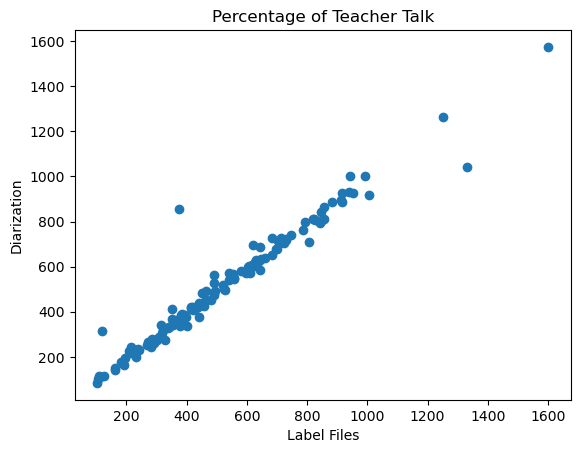

In [101]:
%matplotlib inline
plt.title("Duration of Teacher Talk")
plt.xlabel("Label Files")
plt.ylabel("Diarization")
plt.scatter(merged["teacher_duration_x"], merged["teacher_duration_y"]);

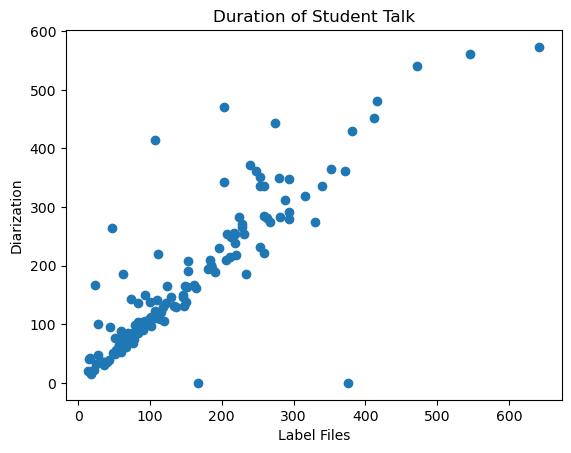

In [102]:
%matplotlib inline
plt.title("Duration of Student Talk")
plt.xlabel("Label Files")
plt.ylabel("Diarization")
plt.scatter(merged["student_duration_x"], merged["student_duration_y"]);

In [103]:
output_dir = 'whisper_diarization_dfs'
os.makedirs(output_dir, exist_ok=True)

In [104]:
label_files = [label for label in sorted(os.listdir("Label_Files/")) if (("speaker" not in label) & (".ipynb_checkpoints" not in label))]

In [105]:
import pandas as pd
import os
from collections import defaultdict
from typing import List, Tuple, Dict
import pickle

def is_overlap(start1: float, end1: float, start2: float, end2: float) -> bool:
    """Check if two time intervals overlap."""
    return max(start1, start2) < min(end1, end2)

def get_dominant_label(labels_str: str) -> str:
    """Get the most frequent label from a space-separated string of labels."""
    if not labels_str:
        return ""
    labels = labels_str.split()
    if not labels:
        return ""
    return max(set(labels), key=labels.count)

def add_consecutive_labels(df: pd.DataFrame) -> pd.DataFrame:
    """Add columns for previous and next labels."""
    df = df.copy()
    df['prev_label'] = df['predominant_label'].shift(1)
    df['next_label'] = df['predominant_label'].shift(-1)
    return df

def combine_consecutive_rows(df: pd.DataFrame) -> pd.DataFrame:
    """Combine consecutive rows with the same predominant label."""
    if df.empty:
        return df
    
    combined_rows = []
    current_row = df.iloc[0].copy()
    
    for i in range(1, len(df)):
        if df.iloc[i]['predominant_label'] == current_row['predominant_label']:
            current_row['end'] = df.iloc[i]['end']
            current_row['duration'] = current_row['end'] - current_row['start']
        else:
            combined_rows.append(current_row)
            current_row = df.iloc[i].copy()
    
    combined_rows.append(current_row)
    return pd.DataFrame(combined_rows)

In [106]:
import pandas as pd

def combine_close_segments(diarization_dict, threshold_ms):
    combined_dict = {}
    
    for key, df in diarization_dict.items():
        # Make a copy to avoid modifying original
        temp_df = df.copy().reset_index(drop=True)
        
        # Initialize list to store combined rows
        combined_rows = []
        current_row = temp_df.iloc[0].to_dict()
        
        for i in range(1, len(temp_df)):
            next_row = temp_df.iloc[i]
            
            # Calculate gap between current segment end and next segment start
            time_gap = next_row['start'] - current_row['end']
            
            # If same speaker and gap is less than threshold, combine segments
            if (next_row['speaker'] == current_row['speaker']) and (time_gap < threshold_ms):
                # Update end time and duration of current segment
                current_row['end'] = next_row['end']
                current_row['duration'] = current_row['end'] - current_row['start']
            else:
                # Add current segment to results and start new segment
                combined_rows.append(current_row)
                current_row = next_row.to_dict()
        
        # Add the last segment
        combined_rows.append(current_row)
        
        # Convert back to DataFrame
        combined_dict[key] = pd.DataFrame(combined_rows)
    
    return combined_dict

# Create the two versions with different thresholds
def create_combined_versions(diarization_dict):
    combined_diarization_dict_500 = combine_close_segments(diarization_dict, 500)
    combined_diarization_dict_250 = combine_close_segments(diarization_dict, 250)
    return combined_diarization_dict_500, combined_diarization_dict_250

In [107]:
# Assuming you have your original diarization_dict
combined_diarization_dict_500, combined_diarization_dict_250 = create_combined_versions(diarization_dict)

In [108]:
# Create a copy of the dictionary to store results
transcribed_dict = {}

In [109]:
import torch 
torch.cuda.empty_cache()

In [ ]:
import pickle

In [109]:
# Path to the folder containing the CSV files
STABLE_TS_FOLDER = 'stable_ts_csv'

# Initialize the dictionary to store the DataFrames
tl_transcripts = {}

# Iterate over the CSV files in the folder
for csv_file in os.listdir(STABLE_TS_FOLDER):
    if csv_file.endswith('.csv'):  # Ensure it's a CSV file
        # Extract the key by removing the file extension
        file_key = os.path.splitext(csv_file)[0]
        # Read the CSV file into a DataFrame
        file_path = os.path.join(STABLE_TS_FOLDER, csv_file)
        tl_transcripts[file_key] = pd.read_csv(file_path)

In [111]:
aligned_dict = {}

In [112]:
for label in label_files:
    
    df = pd.read_csv(f"Label_Files/{label}", sep = "\t", header = None)
    df.columns = ["start", "end", "label"]

    clip = label.split("_")[0]

    transcript_df = combined_diarization_dict_500[clip] 
    
    # Reset the index of the filtered DataFrame
    transcript_df = transcript_df.reset_index(drop=True)
    
    labels = []
    predominant_labels = []
    max_overlaps = []
    durations = []
    all_overlaps = []
    
    for i, row in transcript_df.iterrows():
    
        durations.append(row["end"] - row["start"])
        
        overlaps = df.apply(
            lambda x: (x['label'], min(row['end'], x['end']) - max(row['start'], x['start'])) 
            if is_overlap(row['start'], row['end'], x['start'], x['end']) else (None, 0), 
            axis=1
        )
        
        # Filter out non-overlapping entries
        overlaps = overlaps[overlaps.apply(lambda x: x[0] is not None)]
        
        # Extract labels and their corresponding overlap times
        overlapping_labels = overlaps.apply(lambda x: x[0])
        
        overlapping_labels.reset_index(drop=True, inplace=True)
        # Add the list of overlapping labels to the labels
        
        labels.append(" ".join(overlapping_labels))
        
        # Initialize a defaultdict to store the summed values
        collapsed_dict = defaultdict(float)
        
        # Iterate over the series and sum values for each key
        for item in overlaps:
            key, value = item
            collapsed_dict[key] += value
        
        # Convert the defaultdict back to a list of tuples (or a Pandas series if needed)
        collapsed_list = list(collapsed_dict.items())
        non_empty_label_overlap = [item for item in collapsed_list if item[0] is not None]
        collapsed_series = pd.Series(collapsed_list)
        
        
        overlap_times = collapsed_series.apply(lambda x: x[1])
        overlap_labels = collapsed_series.apply(lambda x: x[0])
        
        
        overlap_times.reset_index(drop=True, inplace=True)
        overlap_labels.reset_index(drop=True, inplace=True)
        
        # print(len(overlap_labels), len(overlap_times))
        
        # Determine the predominant label (the one with the greatest overlap time)
        if not overlap_times.empty:
           # print(overlap_times)
            predominant_label = overlap_labels.iloc[overlap_times.idxmax()]
            predominant_labels.append(predominant_label)
            max_overlap = overlap_times.iloc[overlap_times.idxmax()]
            max_overlaps.append(max_overlap)
            all_overlaps.append(non_empty_label_overlap)
        else:
            predominant_labels.append("")
            max_overlaps.append("")
            all_overlaps.append("")

    
    # print(transcript_df.shape)
    transcript_df["duration"] = durations
    transcript_df["label"] = labels
    transcript_df["max_overlap"] = max_overlaps
    transcript_df['predominant_label'] = predominant_labels
    most_common_label = transcript_df['label'].apply(get_dominant_label)
    transcript_df['most_common_label'] = most_common_label
    transcript_df["all_overlaps"] = all_overlaps
    # print(transcript_df.shape)
    
    label_lists = [element.split(" ") for element in transcript_df["label"].tolist()]
        
    transcript_df = add_consecutive_labels(transcript_df)
    
    aligned_dict[clip] = transcript_df

In [114]:
def txt2rttm(path_to_txt, output_folder):
    """
    Convert a txt file with the format 'onset offset speaker' to an RTTM file.
    Parameters
    ----------
    path_to_txt : str
        Path to the txt file.
    output_folder : str
        Path to the output folder.
    Returns
    -------
    None
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    basename = os.path.splitext(os.path.basename(path_to_txt))[0]
    output_path = os.path.join(output_folder, basename + '.rttm')
    
    with open(path_to_txt, 'r') as txt, open(output_path, 'w') as rttm:
        for line in txt:
            onset, offset, speaker = line.rstrip().split('\t')
            if ((onset != "") & (offset != "") & (speaker != "")):
                dur = float(offset) - float(onset)
                rttm.write(f"SPEAKER {basename} 1 {onset} {dur} <NA> <NA> {speaker} <NA>\n")

def save_as_txt(clip_name, df, output_folder):
    """
    Save only the required columns (onset, offset, speaker) to a txt file.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    # Ensure the required columns exist in the dataframe
    required_columns = ['start', 'end', 'speaker']
    
    # Select only the required columns, assuming they exist in the dataframe
    # If column names are different, modify this part accordingly
    df_subset = df[required_columns].copy()
    
    file_path = os.path.join(output_folder, clip_name)
    df_subset.to_csv(file_path, sep="\t", index=False, header=False)
    return file_path


In [115]:
output_folder = "whisper_diarization_rttm"

In [116]:
for clip_name, df in diarization_dict.items():
    path_to_txt = save_as_txt(clip_name, df, "diarization_txt")
    txt2rttm(path_to_txt, output_folder)

In [117]:
def gather_groundtruth_rttm_paths(folder_path):
    data = []
    
    # Loop through the files in the folder
    for filename in os.listdir(folder_path):
        # Ensure it's a file and has an rttm extension
        if filename.endswith(".rttm"):
            clip_name = os.path.splitext(filename)[0].split("_")[0]
            file_path = os.path.join(folder_path, filename)
            data.append({"clip": clip_name, "path": file_path})
    
    # Create a DataFrame from the gathered data
    df = pd.DataFrame(data, columns=["clip", "path"])
    
    return df

In [118]:
folder_path = "./whisper_diarization_rttm/"
whisper_rttm_df = gather_groundtruth_rttm_paths(folder_path)
whisper_rttm_df.rename(columns={"path": "rttm_df_path"}, inplace=True)

In [180]:
folder_path = "./label_files_rttm"
groundtruth_rttm_df = gather_groundtruth_rttm_paths(folder_path)
groundtruth_rttm_df .rename(columns={"path": "rttm_df_path"}, inplace=True)

In [176]:
merged_df = groundtruth_rttm_df.merge(whisper_rttm_df, on='clip', how='outer')

In [185]:
def compute_metrics(groundtruth, hypothesis):
    metric_coverage = SegmentationCoverage()
    metric_purity = SegmentationPurity()
    coverage = metric_coverage(groundtruth, hypothesis)
    purity = metric_purity(groundtruth, hypothesis)
    return coverage, purity

In [186]:
results = {
    'clip': [],
    'rttm_df_path_coverage': [],
    'rttm_df_path_purity': [],
    'diarization_rttm_df_path_coverage': [],
    'diarization_rttm_df_path_purity': [],
}

In [187]:
for _, row in merged_df.iterrows():
    clip = row['clip']
    groundtruth_path = row['rttm_df_path']
    _, groundtruth = load_rttm(groundtruth_path).popitem()
    
    for col in ['diarization_rttm_df_path']:
        if pd.notna(row[col]):
            hypothesis_path = row[col]
            _ ,hypothesis = load_rttm(hypothesis_path).popitem()
            coverage, purity = compute_metrics(groundtruth, hypothesis)
        else:
            coverage, purity = None, None

        results[f'{col}_coverage'].append(coverage)
        results[f'{col}_purity'].append(purity)
    
    results['clip'].append(clip)
    results['rttm_df_path_coverage'].append(None)
    results['rttm_df_path_purity'].append(None)

In [188]:
results_df = pd.DataFrame(results)

In [193]:
def calculate_f2_score(df, coverage_col, purity_col):
    # Ensure the columns exist in the DataFrame
    if coverage_col not in df.columns or purity_col not in df.columns:
        raise ValueError(f"Columns {coverage_col} and/or {purity_col} not found in DataFrame")
    
    # Calculate precision and recall
    recall = df[coverage_col]
    precision = df[purity_col]
    
    # Calculate F2 score
    f2_score = 2 * (precision * recall) / (precision + recall)
    
    return f2_score

In [194]:
f2_scores = pd.concat([results_df, calculate_f2_score(results_df, "diarization_rttm_df_path_coverage", "diarization_rttm_df_path_purity")], axis = 1)

In [195]:
f2_scores.rename(columns = {0: "pseudo_f1"}, inplace = True)

In [151]:
f2_scores["pseudo_f1"].mean()

0.9104888090789224

In [201]:
f2_scores["diarization_rttm_df_path_coverage"].median()

0.47604452095704747

In [202]:
f2_scores["pseudo_f1"].median()

0.6308786805284503

In [137]:
f2_scores[["clip", "diarization_rttm_df_path_coverage", "diarization_rttm_df_path_purity", "pseudo_f1"]].sort_values(by = "pseudo_f1", ascending = False).head(5)

,clip,diarization_rttm_df_path_coverage,diarization_rttm_df_path_purity,pseudo_f1
128,008-10,0.975945,0.981246,0.978588
88,088-1,0.983517,0.971388,0.977415
13,254-3,0.969041,0.979213,0.974101
122,008-6,0.980115,0.967887,0.973963
83,105-1,0.974798,0.971046,0.972918


In [147]:
f2_scores[["clip", "diarization_rttm_df_path_coverage", "diarization_rttm_df_path_purity", "pseudo_f1"]].sort_values(by = "pseudo_f1", ascending = False).tail(5)

,clip,diarization_rttm_df_path_coverage,diarization_rttm_df_path_purity,pseudo_f1
19,252-2,0.708227,0.950465,0.811657
7,264-3,0.630720,0.993857,0.771703
115,038-1,0.654225,0.892077,0.754858
18,252-1,0.577597,0.969878,0.724016
0,273-4,0.083572,1.000000,0.154252


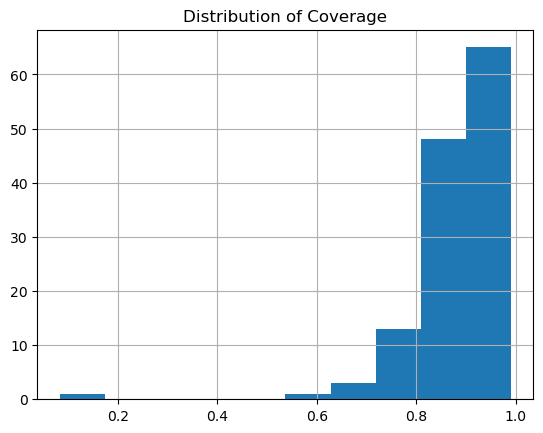

In [138]:
plt.title("Distribution of Coverage")
results_df["diarization_rttm_df_path_coverage"].hist();

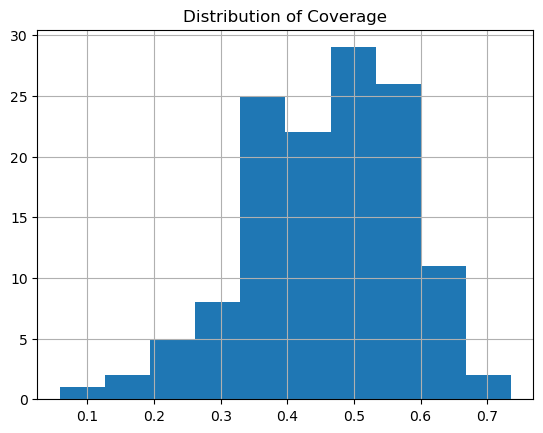

In [76]:
plt.title("Distribution of Coverage")
results_df["diarization_rttm_df_path_coverage"].hist();

In [140]:
aligned_transcripts = {}

for clip, transcript_df in tl_transcripts.items():
    # Ensure both the transcript and diarization data exist for the clip
    if clip not in aligned_dict:
        print(f"Warning: No diarization data found for {clip}. Skipping...")
        continue

    diarization_df = aligned_dict[clip]
    # Reset the index for the aligned DataFrame
    diarization_df = diarization_df.reset_index(drop=True)
    diarization_df['transcript'] = ''  # Add a new column for the aligned transcript

    # Iterate over diarization segments
    for i, diarization_row in diarization_df.iterrows():
        segment_start = diarization_row['start']
        segment_end = diarization_row['end']

        # Filter words that overlap with the diarization segment
        overlapping_words = transcript_df[
            (transcript_df['start'] < segment_end) &
            (transcript_df['end'] > segment_start)
        ]

        # Concatenate overlapping words to form the segment transcript
        concatenated_transcript = ' '.join(overlapping_words['word'].tolist())
        diarization_df.at[i, 'transcript'] = concatenated_transcript

    # Save the aligned diarization DataFrame with transcripts to the result dictionary
    aligned_transcripts[clip] = diarization_df

In [145]:
output_dir = 'combined_500ms_whisper_diarization_stable_ts_aligned'
os.makedirs(output_dir, exist_ok=True)

In [146]:
for clip_name, diarization in aligned_transcripts.items():
    # Create filename - ensure it's a valid filename by removing problematic characters
    safe_filename = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(clip_name))[0]}.csv")
    
    try:
        # Convert diarization to DataFrame if it isn't already
        if not isinstance(diarization, pd.DataFrame):
            df = pd.DataFrame(diarization)
            df = df[df["speaker"] == "Teacher"]
        else:
            df = diarization
            df = df[df["speaker"] == "Teacher"]
            
        # Save to CSV
        df.to_csv(safe_filename, index=False)
        print(f"Saved: {safe_filename}")
        
    except Exception as e:
        print(f"Error saving {clip_name}: {str(e)}")

Saved: combined_500ms_whisper_diarization_stable_ts_aligned/008-7.csv
Saved: combined_500ms_whisper_diarization_stable_ts_aligned/131-6.csv
Saved: combined_500ms_whisper_diarization_stable_ts_aligned/131-7.csv
Saved: combined_500ms_whisper_diarization_stable_ts_aligned/008-6.csv
Saved: combined_500ms_whisper_diarization_stable_ts_aligned/123-4.csv
Saved: combined_500ms_whisper_diarization_stable_ts_aligned/008-4.csv
Saved: combined_500ms_whisper_diarization_stable_ts_aligned/038-2.csv
Saved: combined_500ms_whisper_diarization_stable_ts_aligned/131-5.csv
Saved: combined_500ms_whisper_diarization_stable_ts_aligned/108-1.csv
Saved: combined_500ms_whisper_diarization_stable_ts_aligned/131-4.csv
Saved: combined_500ms_whisper_diarization_stable_ts_aligned/038-3.csv
Saved: combined_500ms_whisper_diarization_stable_ts_aligned/008-5.csv
Saved: combined_500ms_whisper_diarization_stable_ts_aligned/123-1.csv
Saved: combined_500ms_whisper_diarization_stable_ts_aligned/105-2.csv
Saved: combined_500m